In [1]:
import sys 
sys.path.append(r"C:\Users\a-sochat\development\Qcodes_Sohail_Clone\Qcodes")

import numpy as np

import qcodes as qc
from qcodes.instrument.parameter import ManualParameter
from qcodes.sweep import sweep, nest, chain, SweepMeasurement
from qcodes import ParamSpec, new_data_set, new_experiment, Station

from qcodes.dataset.plotting import plot_by_id

In [2]:
x = ManualParameter("x")
m = ManualParameter("m")
m.get = lambda: "{:.3}".format(np.random.uniform(0, 1))

sweep_object = nest(sweep(x, [0, 1, 2, 3, 4, 5, 6]), m)

In [3]:
experiment = new_experiment("sweep_measure", sample_name="none")
station = Station()
meas = SweepMeasurement(exp=experiment, station=station)

In [4]:
with meas.run() as datasaver: 
    for data in sweep_object: 
        datasaver.addResult(data)
    
    dataid = datasaver.id  # convenient to have for plotting

Starting experimental run with id: 15


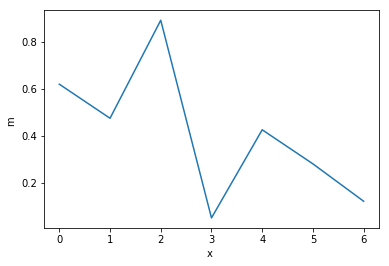

In [5]:
fig = plot_by_id(dataid)

In [6]:
class Resonator(qc.Instrument):
    def __init__(self, name, resonance_frequencies): 
        super().__init__(name)
        self._resonance_frequencies = resonance_frequencies
    
        self._frequency = 0  # [Hz]
        self._peak_width = 100  # [Hz]
    
        self.add_parameter(
            name="frequency", 
            set_cmd=self._set_frequency,
            unit="Hz"
        )
        
    def _set_frequency(self, freq): 
        self._frequency = freq
        
    def get_amplitude(self):
        r = 0
        for resonance_frequency in self._resonance_frequencies:
            rsqr = (self._frequency - resonance_frequency)**2 / self._peak_width **2
            r += np.exp(-rsqr)
        return r

In [7]:
r = Resonator("resonator", [300, 1000, 1200])

In [8]:
station = qc.Station(r)

In [9]:
def adaptive_sampler(last_measurement, start, end, step):
    
    def inner(): 
        
        rng = np.linspace(start, end, step)
        segments = list(zip(rng[:-1], rng[1:]))        
        measure_buffer = {}
        
        while len(segments): 

            b, e = segments.pop(0)
            
            if b not in measure_buffer.keys():
                yield b
                fb = last_measurement()
                measure_buffer[b] = fb
            else:
                fb = measure_buffer[b]
                
            if e not in measure_buffer.keys():
                yield e
                fe = last_measurement()
                measure_buffer[e] = fe
            else:
                fe = measure_buffer[e]
            
            m = (b + e) / 2
            if m not in measure_buffer.keys():
                yield m 
                fm = last_measurement()
                measure_buffer[m] = fm
            else:
                fm = measure_buffer[m]
            
            linearity_error = abs(fm - (fb + fe) / 2)
    
            if linearity_error > 0.005:
                tmp = [(b, m), (m, e)]
                tmp.extend(segments)
                segments = tmp
    
    return inner

In [14]:
class MeasurementFunction: 
    def __init__(self, station): 
        self._station = station
        self._last_measurement_value = None
    def __call__(self): 
        measurement = self._station.resonator.get_amplitude()
        self._last_measurement_value = measurement
        return {"amplitude": {"unit": "V", "value": measurement, "independent_parameter": False}}
    def last_measurement(self): 
        return self._last_measurement_value

In [15]:
measure_function = MeasurementFunction(station)

sweep_object = nest(
    sweep(r.frequency, adaptive_sampler(measure_function.last_measurement, -1000, 4000, 6)),
    measure_function
)

In [16]:
adaptive_experiment = new_experiment("adaptive_experiment", sample_name="none")
meas = SweepMeasurement(exp=adaptive_experiment, station=station)

In [17]:
with meas.run() as datasaver: 
    for data in sweep_object: 
        datasaver.addResult(data)
    
    dataid = datasaver.id  # convenient to have for plotting

Starting experimental run with id: 17


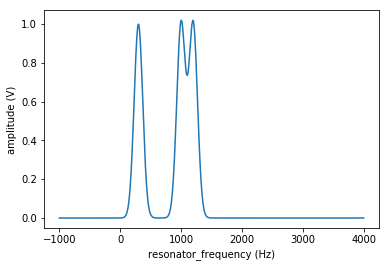

In [18]:
fig = plot_by_id(dataid)